In [ ]:
! pip install hazm
! pip install transformers
! pip install keras_nlp
! pip install datasets

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import DatasetDict, Dataset
import matplotlib.pyplot as plt
import re
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, TFAutoModel, AutoConfig, BertConfig
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Concatenate, Dropout, Dense, Input
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras_nlp.layers import TransformerEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.activations import softmax
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax

In [4]:
! git clone https://github.com/dml-qom/FarsTail

fatal: destination path 'FarsTail' already exists and is not an empty directory.


In [3]:
train = pd.read_csv('/content/FarsTail/data/Train-word.csv', sep='\t')
test = pd.read_csv('/content/FarsTail/data/Test-word.csv', sep='\t')
val = pd.read_csv('/content/FarsTail/data/Val-word.csv', sep='\t')

In [4]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'label' column
train['encoded_label'] = label_encoder.fit_transform(train['label'])
test['encoded_label'] = label_encoder.fit_transform(test['label'])
val['encoded_label'] = label_encoder.fit_transform(val['label'])

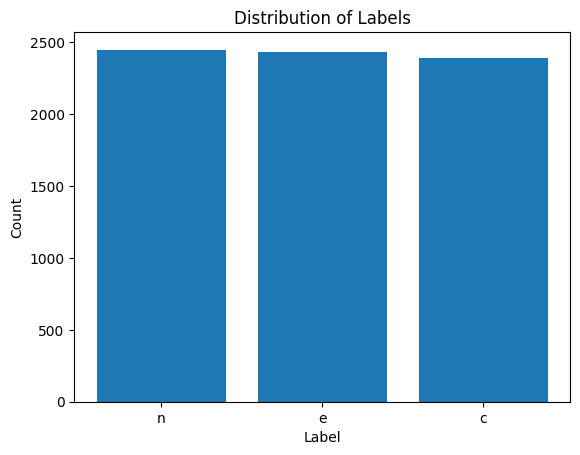

In [5]:
# Count the number of occurrences for each label
label_counts = train['label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [6]:
# Clean text data
def clean_text(text):
    text = re.sub(r"[^\u0600-\u06FF\uFB8A\u067E\u0686\u06AF\u200C\u200F\u0020]", " ", text)
    return text

train['premise'] = train['premise'].apply(clean_text)
train['hypothesis'] = train['hypothesis'].apply(clean_text)

test['premise'] = test['premise'].apply(clean_text)
test['hypothesis'] = test['hypothesis'].apply(clean_text)

val['premise'] = val['premise'].apply(clean_text)
val['hypothesis'] = val['hypothesis'].apply(clean_text)

In [7]:
# Convert the pandas DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
validation_dataset = Dataset.from_pandas(val)

# Create a dictionary containing the datasets
raw_datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "validation": validation_dataset
})

In [7]:
parsbert_config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
parsbert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
parsbert_model = TFAutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", output_hidden_states = True)

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
def tokenize_function(example):
    return parsbert_tokenizer(example["premise"], example["hypothesis"], truncation=True, padding='max_length', max_length=192)

In [10]:
tokenized_datasets = raw_datasets.map(tokenize_function)

Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

In [11]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["encoded_label"],
    shuffle=True,
    batch_size=32,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["encoded_label"],
    shuffle=False,
    batch_size=32,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["encoded_label"],
    shuffle=False,
    batch_size=32,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
parsbert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162841344 
                                                                 
Total params: 162,841,344
Trainable params: 162,841,344
Non-trainable params: 0
_________________________________________________________________


In [13]:
parsbert_model.trainable = False

input_ids = Input(shape=(192,),dtype='int32', name="input_ids")
token_type_ids = Input(shape=(192,),dtype='int32', name="token_type_ids")
attention_mask = Input(shape=(192,), dtype='int32', name="attention_mask")
parsbert = parsbert_model([input_ids, token_type_ids, attention_mask])
hidden_states = parsbert.hidden_states[0]
transformer_encoder = TransformerEncoder(intermediate_dim=3072, num_heads=12, dropout=0.1, layer_norm_epsilon=1e-12, activation="gelu")(hidden_states)
mean = tf.reduce_mean(transformer_encoder, axis=1)  # Average pooling
hidden2 = Dense(512, activation="relu")(mean)
classifier_head = Dense(3, activation="softmax")(hidden2)

In [14]:
model_1 = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=classifier_head)

In [ ]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 192)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 192)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 192)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',     

In [ ]:
batch_size = 32
num_epochs = 30

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

model_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history_1 = model_1.fit(tf_train_dataset, epochs=30, validation_data=tf_validation_dataset)

Epoch 1/30
228/228 [==============================] - 40s 121ms/step - loss: 1.1262 - accuracy: 0.3335 - val_loss: 1.1569 - val_accuracy: 0.3403
Epoch 2/30
228/228 [==============================] - 24s 105ms/step - loss: 1.1191 - accuracy: 0.3373 - val_loss: 1.1044 - val_accuracy: 0.3461
Epoch 3/30
228/228 [==============================] - 26s 113ms/step - loss: 1.1053 - accuracy: 0.3565 - val_loss: 1.0796 - val_accuracy: 0.4027
Epoch 4/30
228/228 [==============================] - 26s 112ms/step - loss: 1.0835 - accuracy: 0.3915 - val_loss: 1.0671 - val_accuracy: 0.4021
Epoch 5/30
228/228 [==============================] - 25s 109ms/step - loss: 1.0573 - accuracy: 0.4272 - val_loss: 1.0709 - val_accuracy: 0.4183
Epoch 6/30
228/228 [==============================] - 26s 113ms/step - loss: 1.0349 - accuracy: 0.4505 - val_loss: 1.0534 - val_accuracy: 0.4535
Epoch 7/30
228/228 [==============================] - 25s 111ms/step - loss: 0.9916 - accuracy: 0.4887 - val_loss: 1.0582 - val_ac

In [ ]:
preds_1 = model_1.predict(tf_test_dataset)
class_preds_1 = np.argmax(preds_1, axis=1)

49/49 [==============================] - 6s 37ms/step


In [ ]:
acc_1 = accuracy_score(class_preds_1, raw_datasets["test"]["encoded_label"])
print("Accuracy of task 1: " + str(acc_1))

Accuracy of task 1: 0.43478260869565216


In [9]:
parsbert_config_for_classification = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3, output_hidden_states = True, num_hidden_layers=3)
parsbert_model_for_classification = TFAutoModelForSequenceClassification.from_config(parsbert_config_for_classification)

In [ ]:
batch_size = 32
num_epochs = 15

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)


parsbert_model_for_classification.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), metrics=["accuracy"])

In [ ]:
history_2 = parsbert_model_for_classification.fit(tf_train_dataset, epochs=num_epochs, validation_data=tf_validation_dataset, callbacks=[callback])

Epoch 1/15
228/228 [==============================] - 102s 386ms/step - loss: 1.1185 - accuracy: 0.3382 - val_loss: 1.1223 - val_accuracy: 0.3247
Epoch 2/15
228/228 [==============================] - 84s 369ms/step - loss: 1.1122 - accuracy: 0.3375 - val_loss: 1.0966 - val_accuracy: 0.3286
Epoch 3/15
228/228 [==============================] - 83s 365ms/step - loss: 1.0900 - accuracy: 0.3827 - val_loss: 1.0610 - val_accuracy: 0.4398
Epoch 4/15
228/228 [==============================] - 79s 345ms/step - loss: 0.9692 - accuracy: 0.5131 - val_loss: 1.1010 - val_accuracy: 0.4574
Epoch 5/15
228/228 [==============================] - 78s 342ms/step - loss: 0.7497 - accuracy: 0.6419 - val_loss: 1.2794 - val_accuracy: 0.4457
Epoch 6/15
228/228 [==============================] - 83s 364ms/step - loss: 0.5434 - accuracy: 0.7574 - val_loss: 1.5037 - val_accuracy: 0.4535
Epoch 7/15
228/228 [==============================] - 84s 367ms/step - loss: 0.3770 - accuracy: 0.8465 - val_loss: 1.7771 - val_a

In [ ]:
preds_2 = parsbert_model_for_classification.predict(tf_test_dataset)
class_preds_2 = np.argmax(softmax(preds_2[0], axis=1), axis=1)

49/49 [==============================] - 6s 107ms/step


In [ ]:
acc_2 = accuracy_score(class_preds_2, raw_datasets["test"]["encoded_label"])
print("Accuracy of task 2: " + str(acc_2))

Accuracy of task 2: 0.45524296675191817


In [ ]:
f1_2 = f1_score(class_preds_2, raw_datasets["test"]["encoded_label"], average='micro')
print("F1-score for task 2: " + str(f1_2))

F1-score for task 2: 0.45524296675191817


In [ ]:
cnf_2 = confusion_matrix(class_preds_2, raw_datasets["test"]["encoded_label"])
print("Confusion Matrix for task 2:")
print(cnf_2)

Confusion Matrix for task 2:
[[219 157 123]
 [159 239 158]
 [132 123 254]]


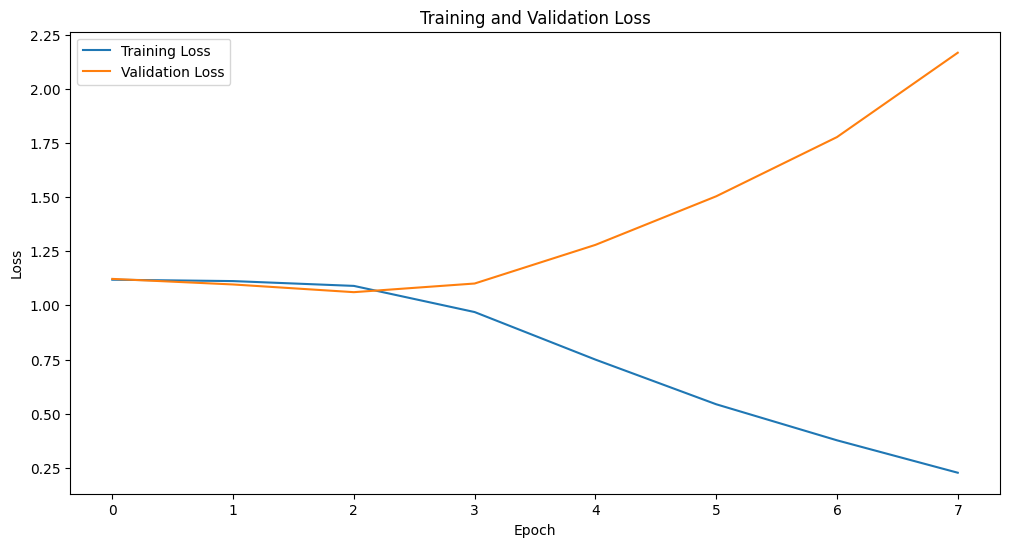

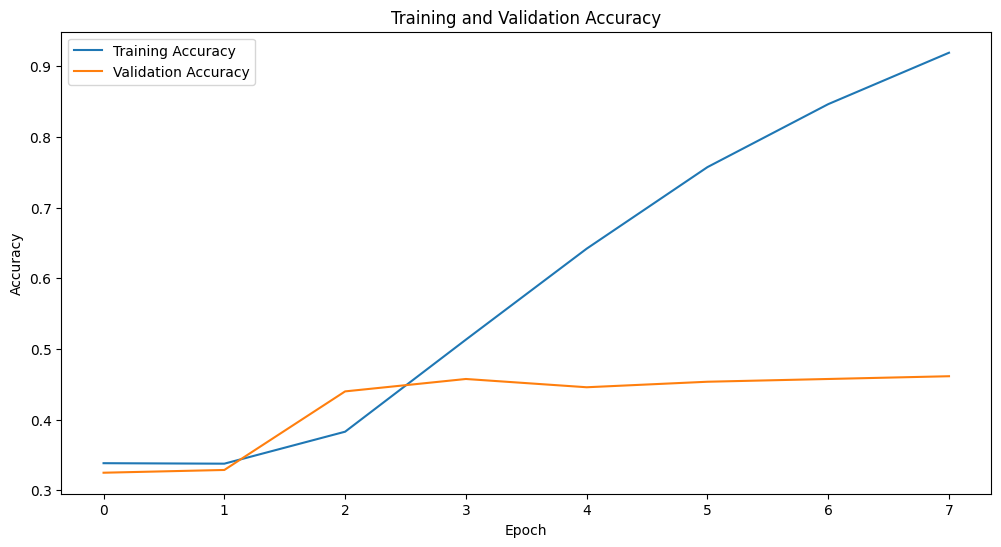

In [ ]:
# Access the training history
training_loss = history_2.history['loss']
validation_loss = history_2.history['val_loss']
training_accuracy = history_2.history['accuracy']
validation_accuracy = history_2.history['val_accuracy']

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
batch_size = 32
num_epochs = 1

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)


parsbert_model_for_classification.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), metrics=["accuracy"])

In [ ]:
num_hidden_layers = list(range(11, 0, -1))
accuracies = []

In [ ]:
for num_layers in tqdm(num_hidden_layers):
  parsbert_model.trainable = True

  input_ids = Input(shape=(192,),dtype='int32', name="input_ids")
  token_type_ids = Input(shape=(192,),dtype='int32', name="token_type_ids")
  attention_mask = Input(shape=(192,), dtype='int32', name="attention_mask")
  parsbert = parsbert_model([input_ids, token_type_ids, attention_mask])
  hidden_states = parsbert.hidden_states[num_layers]
  mean = tf.reduce_mean(hidden_states, axis=1)  # Average pooling
  hidden2 = Dense(512, activation="relu")(mean)
  classifier_head = Dense(3, activation="softmax")(hidden2)

  model_3 = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=classifier_head)

  model_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), metrics=["accuracy"])

  history_3 = model_3.fit(tf_train_dataset, epochs=num_epochs, validation_data=tf_validation_dataset, callbacks=[callback])

  preds_3 = model_3.predict(tf_test_dataset)
  class_preds_3 = np.argmax(preds_3, axis=1)

  acc_3 = accuracy_score(class_preds_3, raw_datasets["test"]["encoded_label"])
  accuracies.append(acc_3)

  0%|          | 0/11 [00:00<?, ?it/s]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._11/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._11/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._11/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._11/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._11/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._11/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._11/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._11/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._11/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._11/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._11/output/dense/kernel

49/49 [==============================] - 22s 385ms/step


  9%|▉         | 1/11 [06:12<1:02:09, 372.98s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._10/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._10/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._10/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._10/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._10/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._10/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._10/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._10/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._10/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._10/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._10/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._10/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._10/output/d

49/49 [==============================] - 20s 350ms/step


 18%|█▊        | 2/11 [11:38<51:46, 345.11s/it]  WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._9/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._9/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._9/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._9/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._9/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._9/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._9/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._9/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._9/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._9/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._9/output/dense/kernel:0

49/49 [==============================] - 18s 315ms/step


 27%|██▋       | 3/11 [16:43<43:34, 326.76s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._8/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._8/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._8/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._8/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._8/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._8/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._8/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._8/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._8/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._8/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._8/output/dense/kernel:0',

49/49 [==============================] - 17s 282ms/step


 36%|███▋      | 4/11 [21:05<35:08, 301.17s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._7/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._7/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._7/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._7/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._7/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._7/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._7/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._7/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._7/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._7/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._7/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._7/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._7/output/dense/kernel:0',

49/49 [==============================] - 15s 249ms/step


 45%|████▌     | 5/11 [25:02<27:49, 278.19s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._6/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._6/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._6/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._6/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._6/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._6/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._6/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._6/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._6/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._6/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._6/output/dense/kernel:0',

49/49 [==============================] - 13s 215ms/step


 55%|█████▍    | 6/11 [28:26<21:04, 252.83s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._5/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._5/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._5/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._5/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._5/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._5/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._5/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._5/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._5/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._5/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._5/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._5/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._5/output/dense/kernel:0',

49/49 [==============================] - 11s 178ms/step


 64%|██████▎   | 7/11 [31:19<15:07, 226.90s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._4/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._4/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._4/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._4/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._4/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._4/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._4/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._4/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._4/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._4/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._4/output/dense/kernel:0',

49/49 [==============================] - 10s 142ms/step


 73%|███████▎  | 8/11 [34:06<10:23, 207.78s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._3/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._3/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._3/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._3/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._3/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._3/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._3/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._3/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._3/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._3/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._3/output/dense/kernel:0',

49/49 [==============================] - 8s 107ms/step


 82%|████████▏ | 9/11 [36:09<06:02, 181.24s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._2/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._2/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._2/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._2/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._2/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._2/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._2/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._2/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._2/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._2/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._2/output/dense/kernel:0',

49/49 [==============================] - 6s 72ms/step


 91%|█████████ | 10/11 [41:51<03:50, 230.91s/it]WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/encoder/layer_._1/attention/self/query/kernel:0', 'tf_bert_model/bert/encoder/layer_._1/attention/self/query/bias:0', 'tf_bert_model/bert/encoder/layer_._1/attention/self/key/kernel:0', 'tf_bert_model/bert/encoder/layer_._1/attention/self/key/bias:0', 'tf_bert_model/bert/encoder/layer_._1/attention/self/value/kernel:0', 'tf_bert_model/bert/encoder/layer_._1/attention/self/value/bias:0', 'tf_bert_model/bert/encoder/layer_._1/attention/output/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._1/attention/output/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/gamma:0', 'tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/beta:0', 'tf_bert_model/bert/encoder/layer_._1/intermediate/dense/kernel:0', 'tf_bert_model/bert/encoder/layer_._1/intermediate/dense/bias:0', 'tf_bert_model/bert/encoder/layer_._1/output/dense/kernel:0'

49/49 [==============================] - 4s 38ms/step


100%|██████████| 11/11 [42:56<00:00, 234.27s/it]


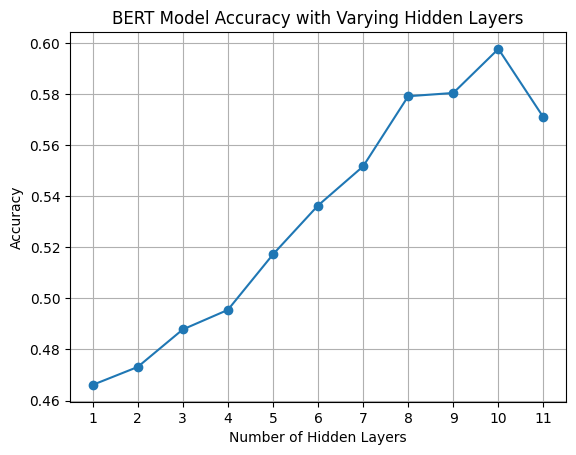

In [ ]:
# Plot the accuracies
plt.plot(num_hidden_layers, accuracies, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.title('BERT Model Accuracy with Varying Hidden Layers')
plt.xticks(num_hidden_layers)
plt.grid(True)
plt.show()

In [12]:
batch_size = 32
num_epochs = 2

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

In [13]:
num_heads = [6, 4, 2]
accuracies = []

In [ ]:
for heads in tqdm(num_heads):
  config_4 = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3, output_hidden_states = True, num_attention_heads=heads, num_hidden_layers=3)
  model_4 = TFAutoModelForSequenceClassification.from_config(config_4)

  model_4.compile(loss=SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), metrics=["accuracy"])

  history_4 = model_4.fit(tf_train_dataset, epochs=num_epochs, validation_data=tf_validation_dataset)

  preds_4 = model_4.predict(tf_test_dataset)
  class_preds_4 = np.argmax(preds_4[0], axis=1)

  acc_4 = accuracy_score(class_preds_4, raw_datasets["test"]["encoded_label"])
  accuracies.append(acc_4)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/2
228/228 [==============================] - 97s 348ms/step - loss: 1.1269 - accuracy: 0.3244 - val_loss: 1.0986 - val_accuracy: 0.3253
Epoch 2/2
49/49 [==============================] - 6s 103ms/step


 33%|███▎      | 1/3 [03:01<06:03, 181.76s/it]

Epoch 1/2
228/228 [==============================] - 88s 325ms/step - loss: 1.2315 - accuracy: 0.3263 - val_loss: 1.0986 - val_accuracy: 0.3247
Epoch 2/2
49/49 [==============================] - 6s 100ms/step


In [ ]:
# Plot the accuracies
plt.plot(num_heads, accuracies, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.title('BERT Model Accuracy with Varying Hidden Layers')
plt.xticks(num_heads)
plt.grid(True)
plt.show()

In [8]:
premise1 = ('او یک زن است')
premise2 = ('او یک مرد است')
hyp = ('او قهرمان المپیک شد')
tokenized_example1 = parsbert_tokenizer(premise1, hyp)
tokenized_example2 = parsbert_tokenizer(premise2, hyp)

In [9]:
parsbert_config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
parsbert_model = TFAutoModelForSequenceClassification.from_config(parsbert_config)

In [ ]:
output1 = softmax(parsbert_model.predict(tokenized_example1['input_ids']), axis=1)
output2 = softmax(parsbert_model.predict(tokenized_example2['input_ids']), axis=1)